## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [9]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5, 0.1]
redice_lr_patient = [5, 10]

In [10]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, patience= reduce_patient, min_lr=1e-12)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalizatio

50000/50000 [==============================] - 15s 294us/step - loss: 1.3589 - acc: 0.5307 - val_loss: 1.5311 - val_acc: 0.4633
Epoch 14/25
50000/50000 [==============================] - 13s 263us/step - loss: 1.3377 - acc: 0.5388 - val_loss: 1.5287 - val_acc: 0.4660
Epoch 15/25
50000/50000 [==============================] - 14s 275us/step - loss: 1.3186 - acc: 0.5445 - val_loss: 1.5176 - val_acc: 0.4710
Epoch 16/25
50000/50000 [==============================] - 14s 285us/step - loss: 1.3006 - acc: 0.5529 - val_loss: 1.5158 - val_acc: 0.4719
Epoch 17/25
50000/50000 [==============================] - 13s 262us/step - loss: 1.2821 - acc: 0.5597 - val_loss: 1.5104 - val_acc: 0.4711
Epoch 18/25
50000/50000 [==============================] - 14s 282us/step - loss: 1.2660 - acc: 0.5641 - val_loss: 1.5021 - val_acc: 0.4731
Epoch 19/25
50000/50000 [==============================] - 13s 265us/step - loss: 1.2481 - acc: 0.5724 - val_loss: 1.4943 - val_acc: 0.4777
Epoch 20/25
50000/50000 [=======

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 16s 320us/step - loss: 2.3758 - acc: 0.2320 - val_loss: 2.2324 - val_acc: 0.2869
Epoch 2/25
50000/50000 [==============================] - 13s 252us/step - loss: 1.8638 - acc: 0.3568 - val_loss: 1.8845 - val_acc: 0.3574
Epoch 3/25
50000/50000 [==============================] - 13s 269us/step - loss: 1.7256 - acc: 0.3990 - val_loss: 1.7900 - val_acc: 0.3822
Epoch 4/25
50000/50000 [==============================] - 14s 285us/step - loss: 1.6455 - acc: 0.4253 - val_loss: 1.7209 - val_acc: 0.4033
Epoch 5/25
50000/50000 [==============================] - 16s 312us/step - loss: 1.5910 - acc: 0.4452 - val_loss: 1.6888 - val_acc: 0.4109
Epoch 6/25
50000/50000 [==============================] - 14s 279us/step - loss: 1.5470 - acc: 0.4589 - val_loss: 1.6536 - val_acc: 0.4207
Epoch 7/25
50000/50000 [==============================] - 14s 277us/step - loss: 1.5093 - acc: 0.4747 - val_loss: 1.

50000/50000 [==============================] - 14s 289us/step - loss: 0.4576 - acc: 0.8661 - val_loss: 1.5271 - val_acc: 0.5237
Epoch 24/25
50000/50000 [==============================] - 14s 287us/step - loss: 0.4370 - acc: 0.8738 - val_loss: 1.5262 - val_acc: 0.5249
Epoch 25/25
50000/50000 [==============================] - 15s 292us/step - loss: 0.4231 - acc: 0.8801 - val_loss: 1.5393 - val_acc: 0.5283
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048      
_________________________________________________________________
hidde

50000/50000 [==============================] - 15s 308us/step - loss: 1.1048 - acc: 0.6233 - val_loss: 1.4938 - val_acc: 0.4753
Epoch 11/25
50000/50000 [==============================] - 19s 373us/step - loss: 1.0751 - acc: 0.6342 - val_loss: 1.4533 - val_acc: 0.4921
Epoch 12/25
50000/50000 [==============================] - 18s 357us/step - loss: 1.0433 - acc: 0.6481 - val_loss: 1.4635 - val_acc: 0.4891
Epoch 13/25
50000/50000 [==============================] - 14s 289us/step - loss: 1.0166 - acc: 0.6558 - val_loss: 1.4113 - val_acc: 0.5044
Epoch 14/25
50000/50000 [==============================] - 14s 288us/step - loss: 0.9905 - acc: 0.6681 - val_loss: 1.4754 - val_acc: 0.4900
Epoch 15/25
50000/50000 [==============================] - 16s 315us/step - loss: 0.9646 - acc: 0.6785 - val_loss: 1.4462 - val_acc: 0.5003
Epoch 16/25
50000/50000 [==============================] - 17s 333us/step - loss: 0.9401 - acc: 0.6874 - val_loss: 1.4731 - val_acc: 0.4876
Epoch 17/25
50000/50000 [=======

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 18s 369us/step - loss: 1.8054 - acc: 0.3743 - val_loss: 2.0335 - val_acc: 0.3303
Epoch 2/25
50000/50000 [==============================] - 15s 300us/step - loss: 1.5434 - acc: 0.4551 - val_loss: 2.0056 - val_acc: 0.3308
Epoch 3/25
50000/50000 [==============================] - 15s 302us/step - loss: 1.4352 - acc: 0.4925 - val_loss: 2.4271 - val_acc: 0.2720
Epoch 4/25
50000/50000 [==============================] - 19s 370us/step - loss: 1.3575 - acc: 0.5210 - val_loss: 2.1108 - val_acc: 0.3154
Epoch 5/25
50000/50000 [==============================] - 17s 340us/step - loss: 1.3034 - acc: 0.5385 - val_loss: 2.0331 - val_acc: 0.3227
Epoch 6/25
50000/50000 [==============================] - 16s 324us/step - loss: 1.2533 - acc: 0.5563 - val_loss: 1.9524 - val_acc: 0.3586
Epoch 7/25
50000/50000 [==============================] - 16s 319us/step - loss: 1.2115 - acc: 0.5743 - val_loss: 2.

50000/50000 [==============================] - 15s 290us/step - loss: 0.6362 - acc: 0.8011 - val_loss: 1.5880 - val_acc: 0.4894
Epoch 24/25
50000/50000 [==============================] - 14s 289us/step - loss: 0.6183 - acc: 0.8063 - val_loss: 1.6715 - val_acc: 0.4677
Epoch 25/25
50000/50000 [==============================] - 15s 300us/step - loss: 0.5984 - acc: 0.8161 - val_loss: 1.5058 - val_acc: 0.4998
Numbers of exp: 10, reduce_factor: 0.10, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_31 (Batc (None, 512)               2048      
_________________________________________________________________
hidde

50000/50000 [==============================] - 14s 285us/step - loss: 1.5923 - acc: 0.4459 - val_loss: 1.6993 - val_acc: 0.4090
Epoch 11/25
50000/50000 [==============================] - 14s 287us/step - loss: 1.5670 - acc: 0.4551 - val_loss: 1.6839 - val_acc: 0.4141
Epoch 12/25
50000/50000 [==============================] - 14s 276us/step - loss: 1.5451 - acc: 0.4616 - val_loss: 1.6719 - val_acc: 0.4200
Epoch 13/25
50000/50000 [==============================] - 14s 271us/step - loss: 1.5230 - acc: 0.4691 - val_loss: 1.6582 - val_acc: 0.4247
Epoch 14/25
50000/50000 [==============================] - 14s 281us/step - loss: 1.5039 - acc: 0.4769 - val_loss: 1.6446 - val_acc: 0.4214
Epoch 15/25
50000/50000 [==============================] - 14s 277us/step - loss: 1.4851 - acc: 0.4826 - val_loss: 1.6351 - val_acc: 0.4274
Epoch 16/25
50000/50000 [==============================] - 15s 295us/step - loss: 1.4684 - acc: 0.4903 - val_loss: 1.6309 - val_acc: 0.4290
Epoch 17/25
50000/50000 [=======

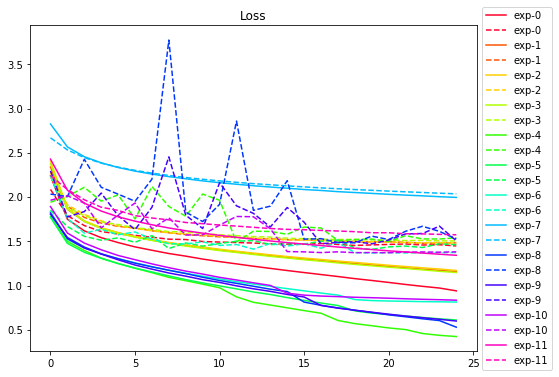

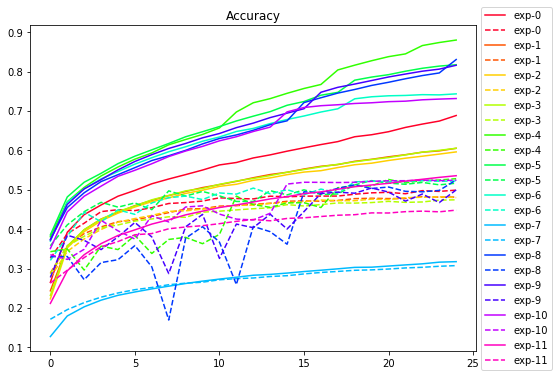

In [11]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()